# Single cell methylation

### initialize definitions

In [1]:
suppressMessages(suppressWarnings(source(here::here("code/init.R"))))

In [2]:
suppressMessages(suppressWarnings(load_cgdb()))

In [3]:
suppressMessages(suppressWarnings(load_plpdb()))

In [4]:
db

cgdb object
21,342,746 CpGs X 24,179 cells

--- root (@db_root): /net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/data/cgdb



In [5]:
db_f <- db_f %>% fill_sort_column()

In [6]:
db_plp_f <- db_plp %>% inner_join_cells(db_f@cells %>% select(cell_id))

Joining, by = "cell_id"


## Generate cell-cycle ordering

Extract coverage in early and late regions per single cell:

In [7]:
tor_covs <- db_plp_f %>% 
    mutate_cpgs(tor_grp = case_when(tor <= 0 ~ "late", tor >= 0 ~ "early")) %>% 
    filter_cpgs(chrom != "chrX", chrom != "chrY", !is.na(tor_grp)) %>% 
    group_by_cpgs(tor_grp) %>% 
    summarise() %>% 
    select(-meth) %>% 
    spread(tor_grp, cov) %cache_df% 
    here("output/tor_cov_per_cell.tsv") %>% 
    as_tibble()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/tor_cov_per_cell.tsv'



Extract the same stratified by CpG content:

In [8]:
tor_cgc_meth <- db_f %>% 
    mutate_cpgs(cg_cont = cut(cg500, c(0,0.02,0.08,0.2)), tor_grp = case_when(tor <= 0 ~ "late", tor >= 0 ~ "early")) %>% 
    filter_cpgs(chrom != "chrX", chrom != "chrY", !is.na(tor_grp), !is.na(cg_cont)) %>% 
    group_by_cpgs(cg_cont, tor_grp) %>% 
    summarise() %>% 
    mutate(avg = meth / cov) %>% 
    pivot_wider(c(cell_id, cg_cont), names_from=tor_grp, values_from=cov:avg) %cache_df% 
    here("output/tor_meth_cgc_per_cell.tsv") %>% 
    as_tibble()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/tor_meth_cgc_per_cell.tsv'



Extract the same stratified by CpG content and AB score:

In [9]:
tor_ab_meth <- calc_cgc_ab_score_sc(db_f, ab_score) %>% 
        rename(ab_score = score) %cache_df% 
    here("output/tor_meth_cgc_ab_score_per_cell.tsv") %>% 
    as_tibble()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/tor_meth_cgc_ab_score_per_cell.tsv'



In [10]:
tor_a_meth <- calc_cgc_ab_score_sc(db_f, a_score) %>% 
        rename(a_score = score) %cache_df% 
    here("output/tor_meth_cgc_a_score_per_cell.tsv") %>% 
    as_tibble()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/tor_meth_cgc_a_score_per_cell.tsv'



In [11]:
tor_b_meth <- calc_cgc_ab_score_sc(db_f, b_score) %>% 
        rename(b_score = score) %cache_df% 
    here("output/tor_meth_cgc_b_score_per_cell.tsv") %>% 
    as_tibble()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/tor_meth_cgc_b_score_per_cell.tsv'



Generate for each cell the ratio between early and late coverage (`early_late_cov`) and the difference in methylation between early and late regions (`meth_late_early_diff`). 

Requirments: 
- CpG content <= 2%
- Early coverage > 2000 and Late coverage > 2000
- Total coverage of early + late higher than 20000

In [12]:
min_cov <- 2e3
min_cov_both <- 2e4
df_cell_cycle_annot <- tor_cgc_meth %>%     
    filter(cg_cont == "(0,0.02]") %>% 
    select(-cg_cont) %>% 
    filter(cov_early >= min_cov, cov_late >= min_cov) %>% 
    left_join(tor_covs %>% filter(early >= min_cov, late >= min_cov)) %>% 
    left_join(db_f@cells) %>% 
    filter(!is.na(early)) %>% 
    mutate(early_late_cov = log2(early / late), meth_late_early_diff = avg_late - avg_early) %>% 
    filter(early + late >= min_cov_both) %cache_df% 
    here("output/sc_cell_cycle_annot.tsv") %>% 
    as_tibble()

Joining, by = "cell_id"
Joining, by = "cell_id"


### In-vivo

Merge with germ layer annotations (FACS):

In [13]:
invivo_sort <- fread(here("data/cells_germ_layer_invivo.tsv")) %>% as_tibble()
df_cell_cycle_invivo <- df_cell_cycle_annot %>% 
    inner_join(invivo_sort) %>% 
    filter(germ_layer != "ExE") %>% 
    select(cell_id, day, germ_layer, avg_late, avg_early, early, late, early_late_cov, early_late_diff = meth_late_early_diff)

Joining, by = "cell_id"


Calculate cell-cycle ordering for each day and germ layer using prinicipal curve on the coverage ratio and methylation difference:

`calc_cell_cycle_ord` function:

- Divides log2(early/late) coverage ratio by its standard deviation.
- Divides late - early methylation difference by its standard deviation.
- Calculates principal curve using:

```r
pc <- princurve::principal_curve(x=mat_norm, start=princurve:::start_circle(mat_norm), stretch=2, smoother = "periodic_lowess")
```
We then:

- define highest early/late coverage ratio as start
- smooth early/late coverage (rolling mean, k=20)
- define the middle of cell cycle as the minimum of smoothed trend
- reorder cells

In [14]:
l_invivo <- df_cell_cycle_invivo %>% 
    mutate(day = ifelse(day == "e8", "e8.5", day)) %>% 
    add_count(day, germ_layer) %>% filter(n >= 50, germ_layer %in% c("epi", "ecto", "endo", "meso")) %>% 
    as.data.frame() %>% 
    plyr::dlply(c("day", "germ_layer"), function(x) calc_cell_cycle_ord(as_tibble(x)))

Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"


Anchor ordering for in-vivo samples:

In [16]:
dir.create(here("output/cell_cycle"))

In [17]:
df_ord_invivo <- l_invivo %>% 
    map_dfr(~ .$df) %>% 
    as_tibble() %>% 
    unite("type", day:germ_layer, remove=FALSE) %>% 
    group_by(day, germ_layer) %>%         
    arrange(day, germ_layer, desc(early_late_cov) ) %>% 
    mutate(
        new_ord = ord - ord[1] + 1, 
        new_ord = ifelse(new_ord >= 0, new_ord, max(new_ord) + abs(min(new_ord)) - abs(new_ord)),
        ord1 = new_ord / max(new_ord)
    ) %>%    
    mutate(
        trend = zoo::rollmean(early_late_cov[order(ord1)], 20, na.pad = TRUE),
        i_mid = zoo::rollmean(ord1[order(ord1)],20)[which.min(trend)],
        ord2 = i_mid - ord1,
        ord2 = ord2 - floor(ord2)
    ) %cache_df% here("output/cell_cycle/invivo.tsv")

Add ordering to CpG content and ab-score objects:

In [18]:
df_ord_cgc_invivo <- tor_cgc_meth %>% 
    inner_join(df_ord_invivo %>% select(cell_id, day, germ_layer, ord2, early_late_cov)) %fcache_df% 
    here("output/cell_cycle/invivo_cgc.tsv")
df_ord_ab_score_invivo <- tor_ab_meth %>% 
    inner_join(df_ord_invivo %>% select(cell_id, day, germ_layer, ord2, early_late_cov)) %fcache_df% 
    here("output/cell_cycle/invivo_ab_score.tsv")

Joining, by = "cell_id"
Joining, by = "cell_id"


### EB

In [19]:
df_cell_cycle_annot %>% filter(line != "mouse", day %in% c("d5", "d6")) %>% count(day, experiment)

day,experiment,n
<chr>,<chr>,<int>
d5,experiment3,659
d5,experiment4,1672
d5,experiment6,1021
d5,experiment8,362
d6,experiment2,746
d6,experiment3,645
d6,experiment5,1169


Experiments 5,6 and 8 had a strong batch effect and therefore they are processed separatley below.

We remove cells with extremly low methylation (less than 0.7)

In [20]:
df_cell_cycle_eb <- df_cell_cycle_annot %>%  
    filter(line != "mouse", day %in% c("d5", "d6"), !(experiment %in% paste0("experiment", c(5,6,8))), avg_early >= 0.7, avg_late >= 0.7) %>% 
    select(cell_id, day, line, sort, experiment, avg_late, avg_early, early, late, early_late_cov, early_late_diff = meth_late_early_diff)

In [21]:
l_ebs <- df_cell_cycle_eb %>% add_count(day, line) %>% filter(n >= 50) %>% as.data.frame() %>% plyr::dlply(c("day", "line"), function(x) calc_cell_cycle_ord(as_tibble(x)))

Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"


In [22]:
df_ord_ebs <- l_ebs %>% 
    map_dfr(~ .$df) %>% 
    as_tibble() %>% 
    unite("type", day:line, remove=FALSE) %>% 
    group_by(day, line) %>%         
    arrange(day, line, desc(early_late_cov) ) %>% 
    mutate(
        new_ord = ord - ord[1] + 1, 
        new_ord = ifelse(new_ord >= 0, new_ord, max(new_ord) + abs(min(new_ord)) - abs(new_ord)),
        ord1 = new_ord / max(new_ord)
    ) %>%    
    mutate(
        trend = zoo::rollmean(early_late_cov[order(ord1)], 20, na.pad = TRUE),
        i_mid = zoo::rollmean(ord1[order(ord1)],20)[which.min(trend)],
        ord2 = i_mid - ord1,
        ord2 = ord2 - floor(ord2)
    ) %>% 
    mutate(type = factor(type, levels = c("d6_wt", "d5_wt", "d5_ko3a", "d5_ko3b", "d6_ko3a", "d6_ko3b"))) %fcache_df% here("output/cell_cycle/ebs.tsv")

In [23]:
df_ord_cgc_ebs <- tor_cgc_meth %>% 
    inner_join(df_ord_ebs %>% select(cell_id, day, line, type, ord2, early_late_cov)) 
df_ord_ab_score_ebs <- tor_ab_meth %>% 
    inner_join(df_ord_ebs %>% select(cell_id, day, line, type, ord2, early_late_cov))

Joining, by = "cell_id"
Joining, by = "cell_id"


Merge in-vivo and ebs data

In [24]:
df_ord_all <- bind_rows(
    df_ord_invivo %>% filter(day == "e7.5") %>% mutate(line = germ_layer) %>% select(-germ_layer),
    df_ord_ebs %>% filter(day %in% c("d5", "d6"))    
)

Adding missing grouping variables: `germ_layer`


Homogenize cell-cycle

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


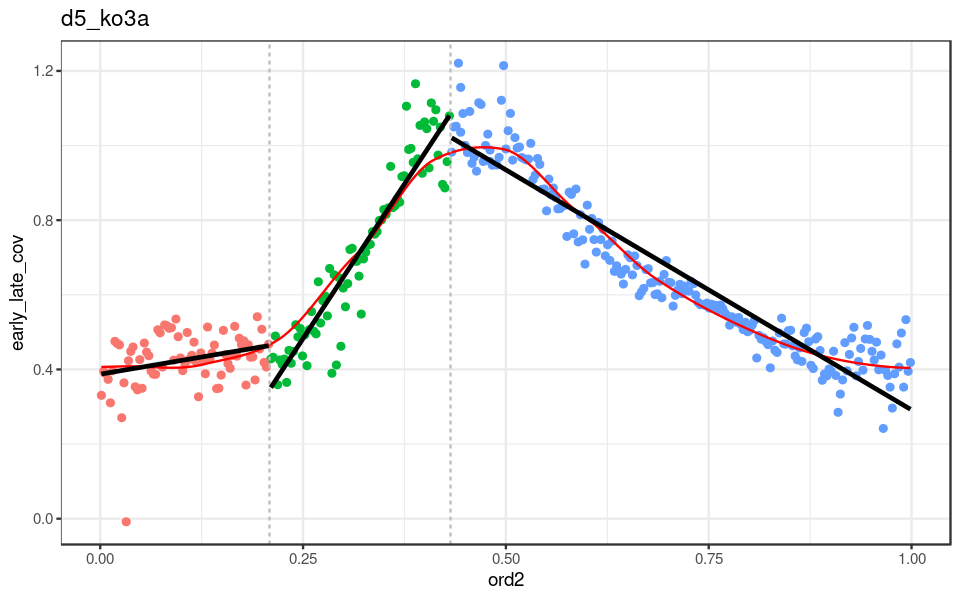

`geom_smooth()` using formula 'y ~ x'

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


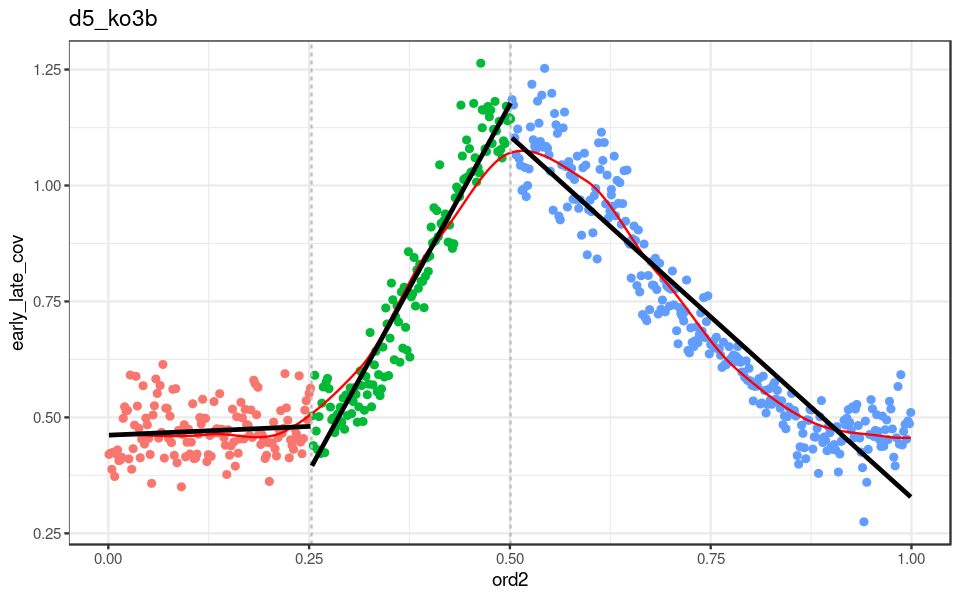

`geom_smooth()` using formula 'y ~ x'

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


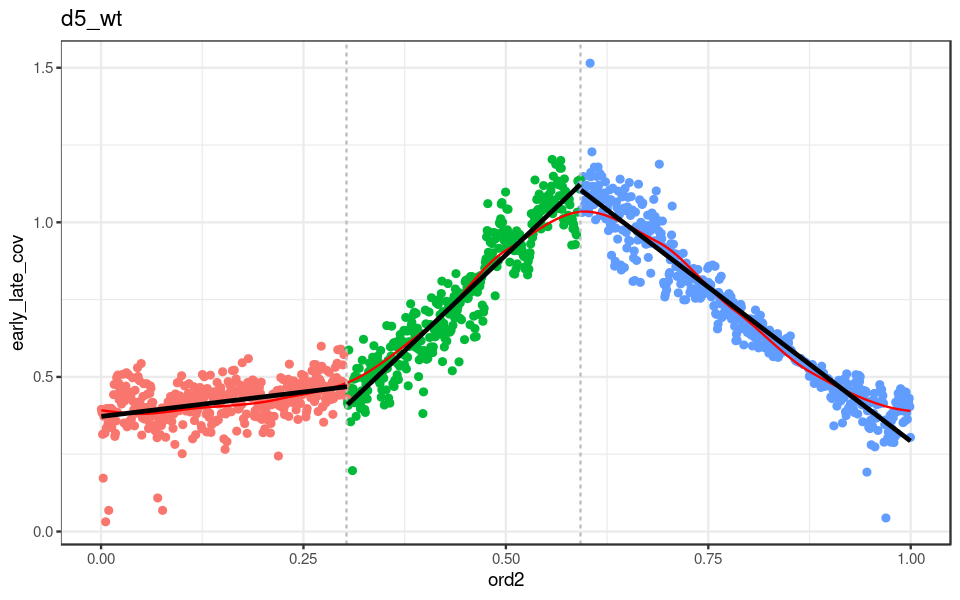

`geom_smooth()` using formula 'y ~ x'

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


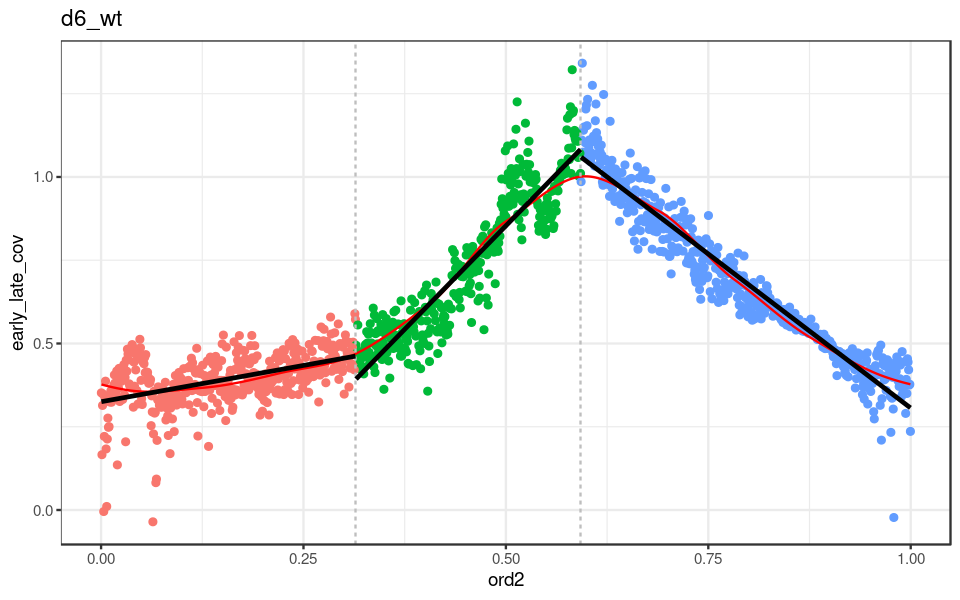

`geom_smooth()` using formula 'y ~ x'

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


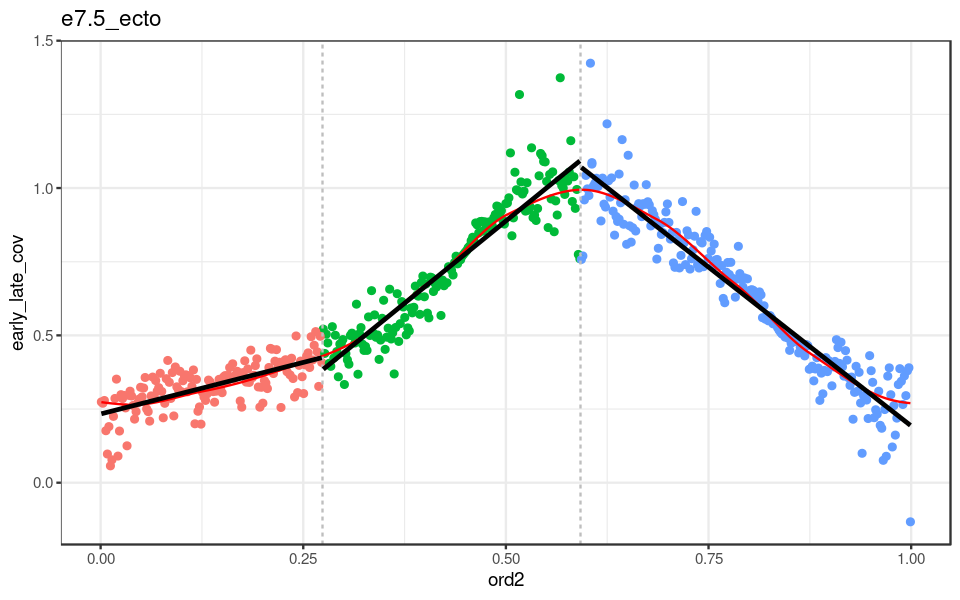

`geom_smooth()` using formula 'y ~ x'



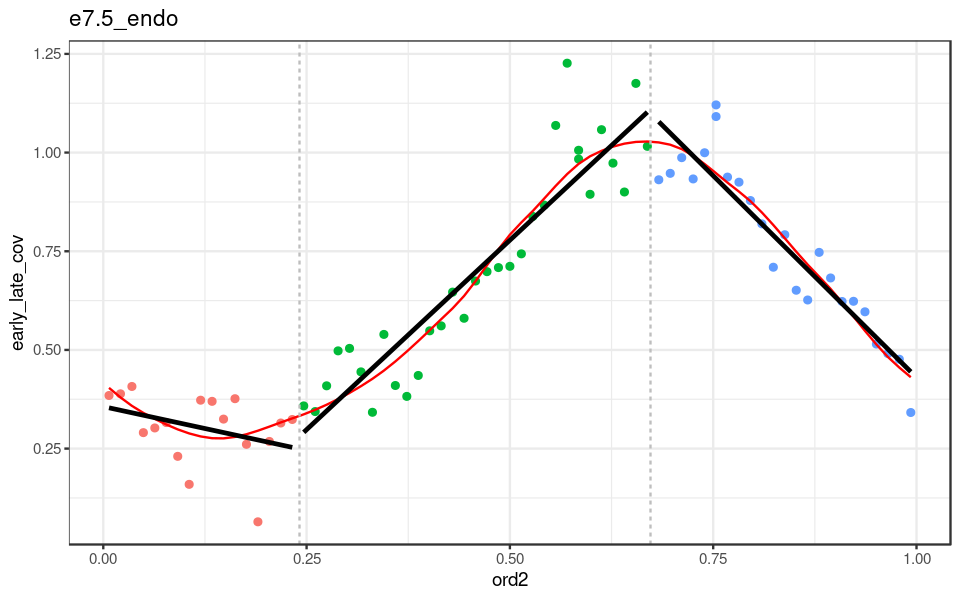

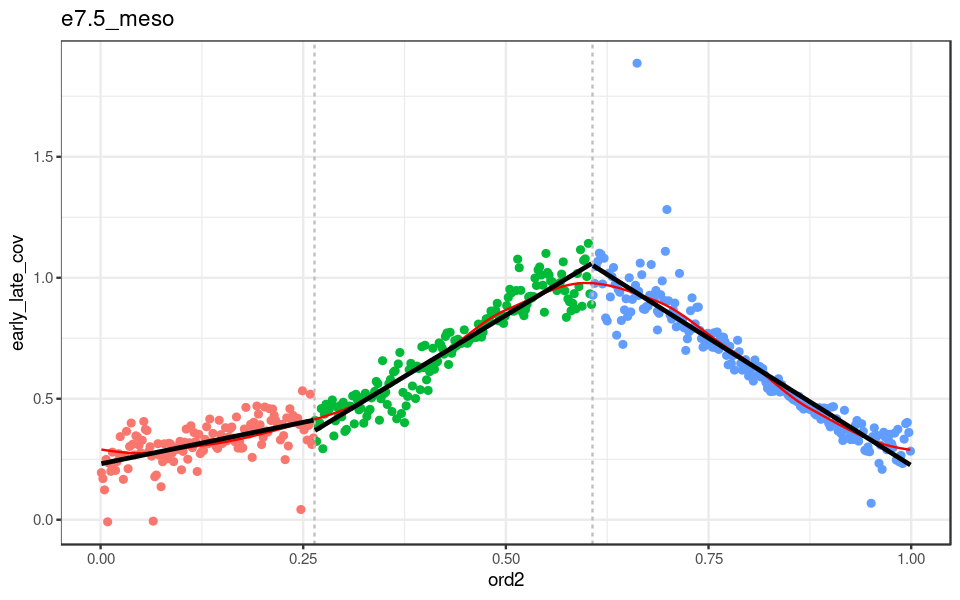

In [53]:
options(repr.plot.width = 8, repr.plot.height = 5)
segmented <- df_ord_all %>% plyr::ddply("type", function(x) x %>% get_cc_segments(n_breaks=2, psi=c(0.2, 0.5), labels=c("S-start", "S-mid", "S-end"))) %fcache_df% here("output/cell_cycle/segmented.tsv") %>% as_tibble()

## Plot in-vivo cell-cycle

In [25]:
df_ord_invivo <- df_ord_invivo %>% filter(day == "e7.5") %>% mutate(line = germ_layer) %>% select(-germ_layer)

Adding missing grouping variables: `germ_layer`


In [26]:
get_cc_early_late_meth_trend(df_ord_invivo %>% filter(germ_layer == "ecto") %>% rename(avg = avg_early)) %>% skimr::skim(.fitted)

get_cc_early_late_meth_trend(df_ord_invivo %>% filter(germ_layer == "ecto") %>% rename(avg = avg_late)) %>% skimr::skim(.fitted)

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             539       
Number of columns          20        
_______________________              
Column type frequency:               
  numeric                  1         
________________________             
Group variables            None      

-- Variable type: numeric ------------------------------------------------------
  skim_variable n_missing complete_rate  mean     sd    p0   p25   p50   p75
1 .fitted               0             1 0.885 0.0227 0.850 0.864 0.888 0.908
   p100 hist                            
1 0.915 "\u2586\u2583\u2583\u2583\u2587"
-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             539       
Number of columns          20        
_______________________              
Column type frequency:               
  numeric                  1  

### Figure 6B

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 15 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 15 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 12 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 12 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'



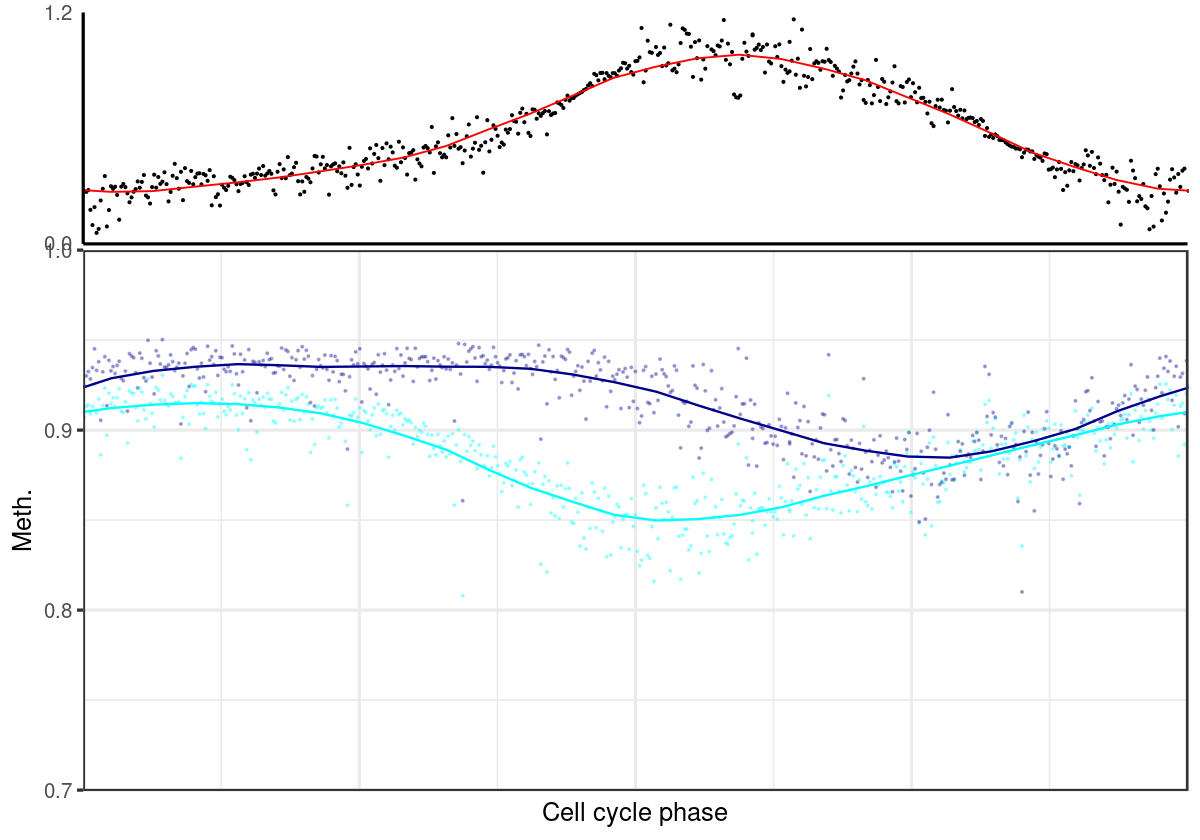

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'



[[1]]

[[2]]

[[3]]


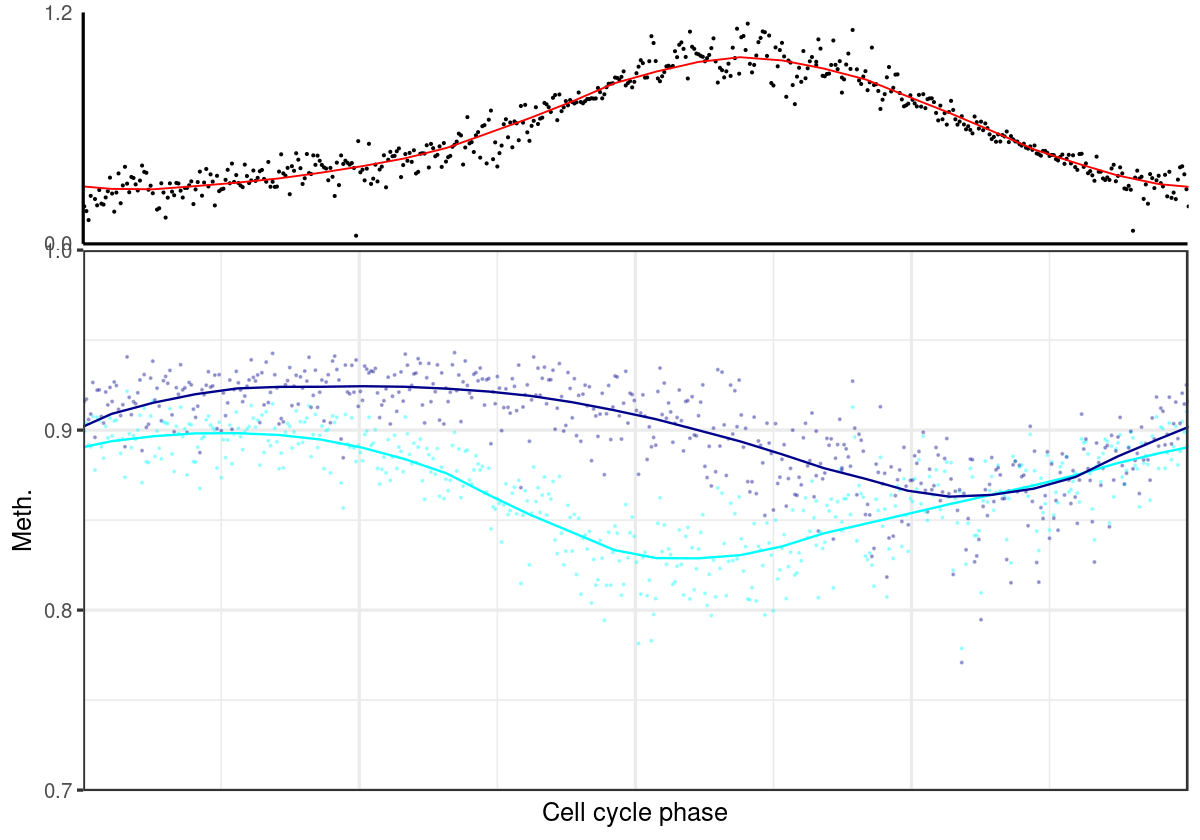

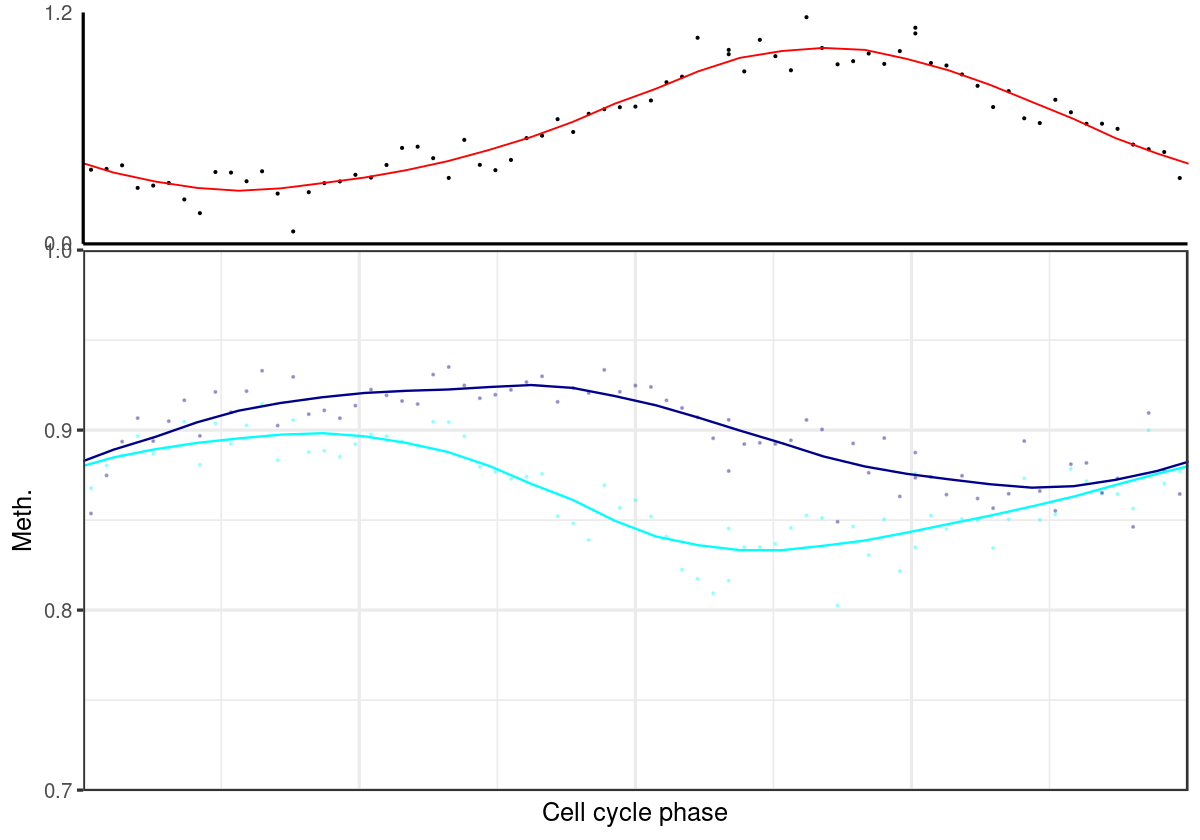

In [27]:
options(repr.plot.width = 10, repr.plot.height = 7)

p_el_invivo_7.5 <- map(c("ecto", "meso", "endo"), ~ df_ord_invivo %>% 
            filter(germ_layer == .x) %>% 
            plot_cc_early_late_meth(point_size=0.1, add_trend_lines = TRUE, y_lim = c(0.7, 1), plot_phase_lines = FALSE, trend_ylim = c(0,1.2))) 

p_el_invivo_7.5

### Figure 6A

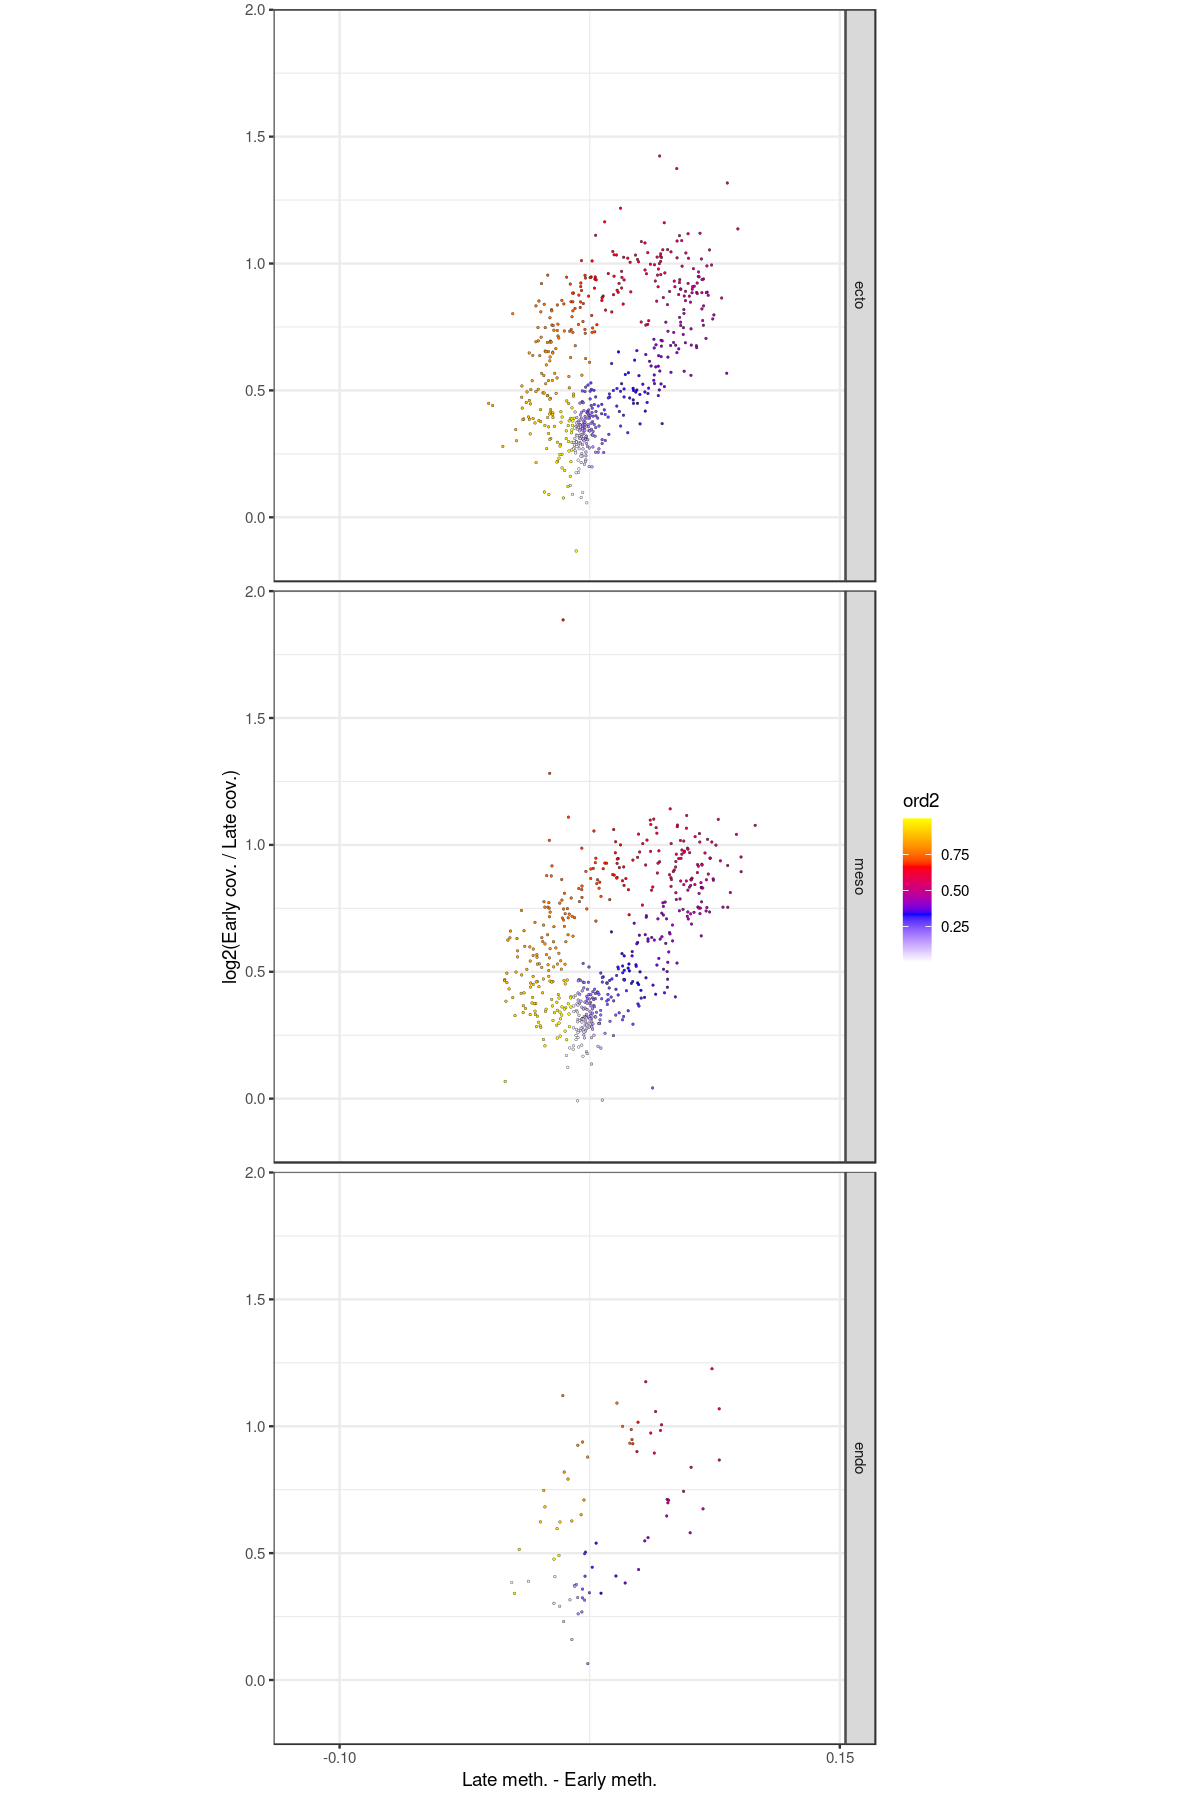

In [28]:
options(repr.plot.width = 10, repr.plot.height = 15)

p_el_invivo_7.5_circle <- df_ord_invivo %>% 
    filter(day == "e7.5") %>% 
    mutate(germ_layer = factor(germ_layer, levels=c("ecto", "meso", "endo"))) %>% 
    plot_cc_circle(point_size=0.4) + 
    facet_grid(germ_layer~.) + 
    scale_x_continuous(breaks=c(-0.1, 0.15)) + 
    coord_cartesian(ylim = c(-0.15, 1.9), xlim=c(-0.12, 0.14))
p_el_invivo_7.5_circle  + theme_bw() + theme(aspect.ratio=1) 


In [29]:
options(repr.plot.width = 8, repr.plot.height = 8)
germ_layer_colors <- c("ecto" = "#5A9E30", "meso" = "#BE89B7", "endo" = "#ED4F93")
df <- df_ord_ab_score_invivo %>% 
    filter(cg_cont == '(0,0.02]') %>% 
    group_by(germ_layer) %>% 
    do({calc_cc_early_late_ab_diff(., low = "(-1.46,-0.734]", high = "(0.281,1.63]")}) %>% 
    ungroup() %>% 
    mutate(germ_layer = factor(germ_layer, levels = names(germ_layer_colors))) %>% 
    filter(!is.na(germ_layer)) 

df <- df %>% 
    pivot_longer(names_sep="_", names_prefix="avg_", cols=starts_with("avg"), names_to=c("tor", "ab_score", "dummy"), values_to="avg") %>% 
    mutate(ab_score = forcats::fct_recode(factor(ab_score), "A-phil" = "l", "B-phil" = "h")) %>% 
    mutate(germ_layer = factor(germ_layer, levels = names(germ_layer_colors))) %>% 
    filter(!is.na(line)) %>% 
    filter(cg_cont == "(0,0.02]")

# show ecto trends on endo and meso
df_ecto <- df %>% filter(germ_layer == "ecto")
df_ecto <- bind_rows(df_ecto %>% mutate(germ_layer = "meso"), df_ecto %>% mutate(germ_layer = "endo")) %>% 
    mutate(germ_layer = factor(germ_layer, levels = names(germ_layer_colors)))

Warning message in is.na(line):
"is.na() applied to non-(list or vector) of type 'closure'"


In [30]:
df_max_repli <- df %>% 
    group_by(germ_layer, tor) %>% 
    filter(ord2 <= 2, ord2 >= 1) %>% 
    summarise(s = ord2[which.max(early_late_cov)])
df_max_repli

germ_layer,tor,s
<fct>,<chr>,<dbl>
ecto,early,1.651786
ecto,late,1.651786
meso,early,1.661822
meso,late,1.661822
endo,early,1.570423
endo,late,1.570423


### Figure 6C

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



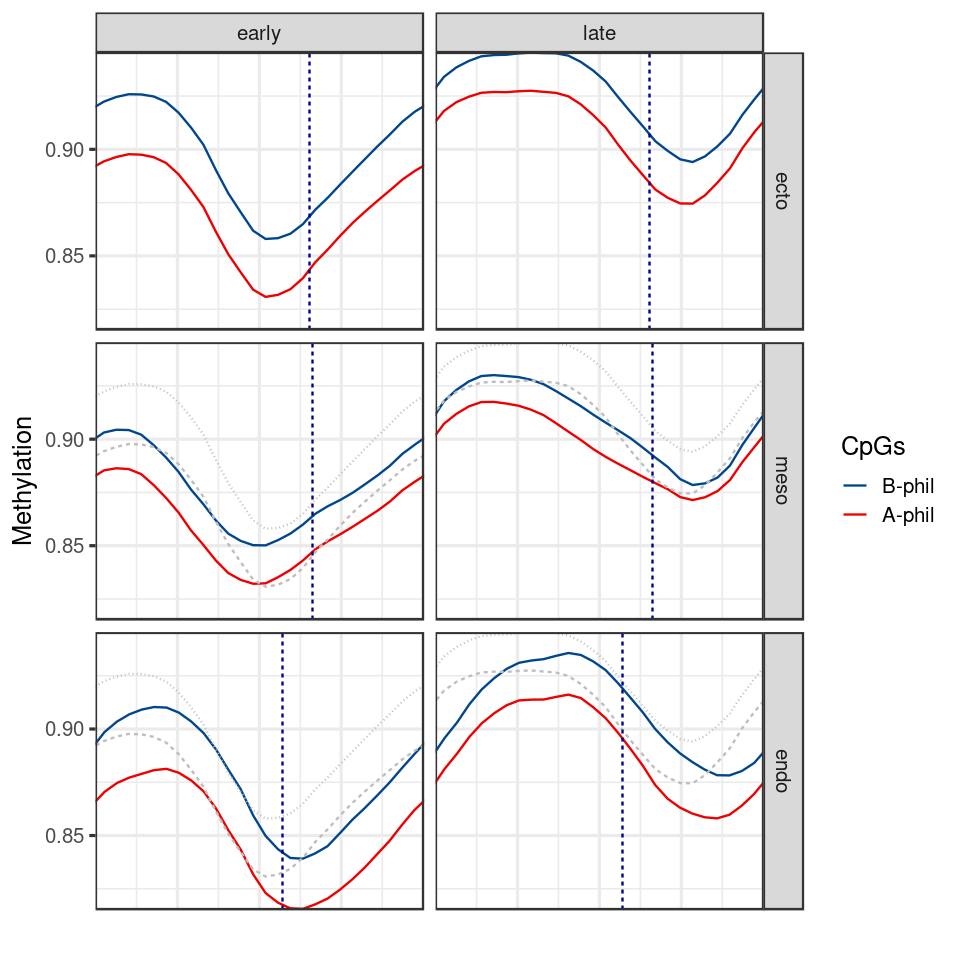

In [31]:
p_ab_trend_invivo <- df %>% 
    mutate(germ_layer = factor(germ_layer, levels = names(germ_layer_colors))) %>%
    ggplot(aes(x=ord2, y=avg, color=ab_score)) + 
        geom_smooth(method="loess", span=0.2, se=FALSE, size=0.5) + 
        geom_smooth(data = df_ecto %>% filter(ab_score == "A-phil"), method="loess", span=0.2, se=FALSE, size=0.5, linetype="dashed", color="gray") + 
        geom_smooth(data = df_ecto %>% filter(ab_score == "B-phil"), method="loess", span=0.2, se=FALSE, size=0.5, linetype="dotted", color="gray") + 
        coord_cartesian(xlim=c(1,2), expand=0) + 
        ggsci::scale_color_lancet(name = "CpGs") + 
        geom_vline(aes(xintercept = s), data = df_max_repli, color = "darkblue", linetype = "dashed") + 
        facet_grid(germ_layer~tor) +  
        xlab("") + 
        ylab("Methylation") + 
        theme(
            axis.text.x = element_blank(), 
            axis.ticks.x = element_blank()
        ) 

p_ab_trend_invivo

### Extended Data Figure 9G

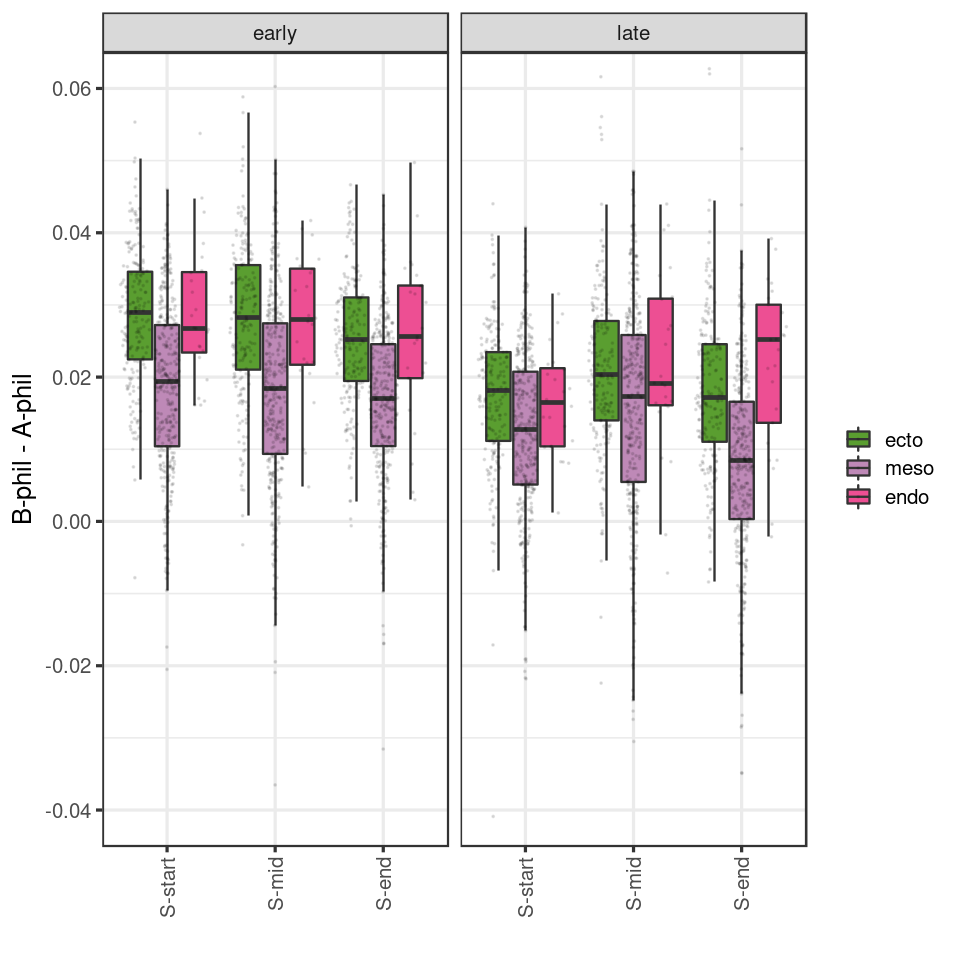

In [32]:
germ_layer_colors <- c("ecto" = "#5A9E30", "meso" = "#BE89B7", "endo" = "#ED4F93")
df_diff <- df %>% distinct(cell_id, cg_cont, day, germ_layer, ord2, tor, ab_score, avg)  %>% spread(ab_score, avg) %>% mutate(diff = `B-phil` - `A-phil`) %>% filter(ord2 >= 1, ord2 <= 2) %>% mutate(ord_grp = cut(ord2, 3, include.lowest=TRUE, labels=c("S-start", "S-mid", "S-end")))
p_ab_diff <- df_diff %>% ggplot(aes(x=ord_grp, y=diff, fill=germ_layer)) + geom_boxplot(outlier.shape=NA) + facet_grid(.~tor) + scale_fill_manual(name="", values=germ_layer_colors) + ylab("B-phil - A-phil") + xlab("") + ggforce::geom_sina(size=0.01, alpha=0.1) + vertical_labs() + coord_cartesian(ylim = c(-0.04, 0.06))

p_ab_diff

In [33]:
df_diff %>% count(tor, ord_grp, germ_layer) %>% arrange(germ_layer)

tor,ord_grp,germ_layer,n
<chr>,<fct>,<fct>,<int>
early,S-start,ecto,198
early,S-mid,ecto,199
early,S-end,ecto,198
late,S-start,ecto,198
late,S-mid,ecto,199
late,S-end,ecto,198
early,S-start,meso,351
early,S-mid,meso,356
early,S-end,meso,352


In [34]:
df_diff %>% group_by(tor, ord_grp) %>% do({broom::tidy(ks.test(.$diff[.$germ_layer == "ecto"], .$diff[.$germ_layer == "meso"]))}) %>% mutate(type = "ecto vs meso") %>% mutate(stars = case_when(p.value <= 0.0001 ~ "****", p.value <= 0.001 ~ "***", p.value <= 0.01 ~ "**", p.value <= 0.05 ~ "*"))
df_diff %>% group_by(tor, ord_grp) %>% do({broom::tidy(ks.test(.$diff[.$germ_layer == "endo"], .$diff[.$germ_layer == "meso"]))}) %>% mutate(type = "endo vs meso") %>% mutate(stars = case_when(p.value <= 0.0001 ~ "****", p.value <= 0.001 ~ "***", p.value <= 0.01 ~ "**", p.value <= 0.05 ~ "*"))
df_diff %>% group_by(tor, ord_grp) %>% do({broom::tidy(ks.test(.$diff[.$germ_layer == "ecto"], .$diff[.$germ_layer == "endo"]))}) %>% mutate(type = "ecto vs endo") %>% mutate(stars = case_when(p.value <= 0.0001 ~ "****", p.value <= 0.001 ~ "***", p.value <= 0.01 ~ "**", p.value <= 0.05 ~ "*"))

tor,ord_grp,statistic,p.value,method,alternative,type,stars
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
early,S-start,0.3774929,4.440892e-16,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs meso,****
early,S-mid,0.3640675,3.996803e-15,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs meso,****
early,S-end,0.3658460,3.663736e-15,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs meso,****
late,S-start,0.2272727,4.183555e-06,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs meso,****
late,S-mid,0.2105753,2.425034e-05,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs meso,****
late,S-end,0.3532197,3.708145e-14,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs meso,****


tor,ord_grp,statistic,p.value,method,alternative,type,stars
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
early,S-start,0.4212963,0.00040083315,Two-sample Kolmogorov-Smirnov test,two-sided,endo vs meso,***
early,S-mid,0.3951311,0.00113293441,Two-sample Kolmogorov-Smirnov test,two-sided,endo vs meso,**
early,S-end,0.4107955,0.00044987569,Two-sample Kolmogorov-Smirnov test,two-sided,endo vs meso,***
late,S-start,0.3201567,0.01508288017,Two-sample Kolmogorov-Smirnov test,two-sided,endo vs meso,*
late,S-mid,0.2827715,0.04390086425,Two-sample Kolmogorov-Smirnov test,two-sided,endo vs meso,*
late,S-end,0.4809091,0.00001812592,Two-sample Kolmogorov-Smirnov test,two-sided,endo vs meso,****


tor,ord_grp,statistic,p.value,method,alternative,type,stars
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
early,S-start,0.10732323,0.94277838,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs endo,NA
early,S-mid,0.08856784,0.98966542,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs endo,NA
early,S-end,0.16767677,0.50363651,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs endo,NA
late,S-start,0.17171717,0.49845073,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs endo,NA
late,S-mid,0.13086265,0.80670065,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs endo,NA
late,S-end,0.29272727,0.03484286,Two-sample Kolmogorov-Smirnov test,two-sided,ecto vs endo,*


## Plot EBs cell cycle

In [35]:
df_ord_ebs <- df_ord_ebs %>% filter(day %in% c("d5", "d6"))  

### Figure 6D,E

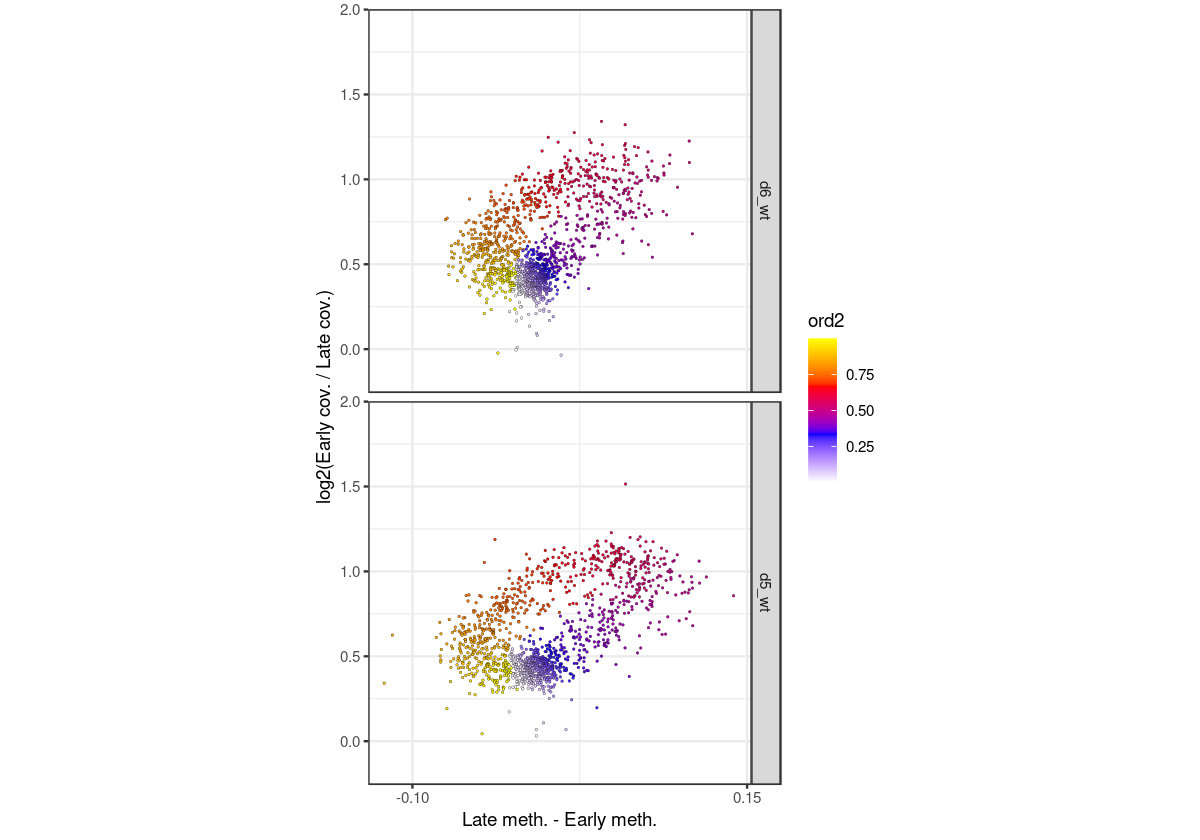

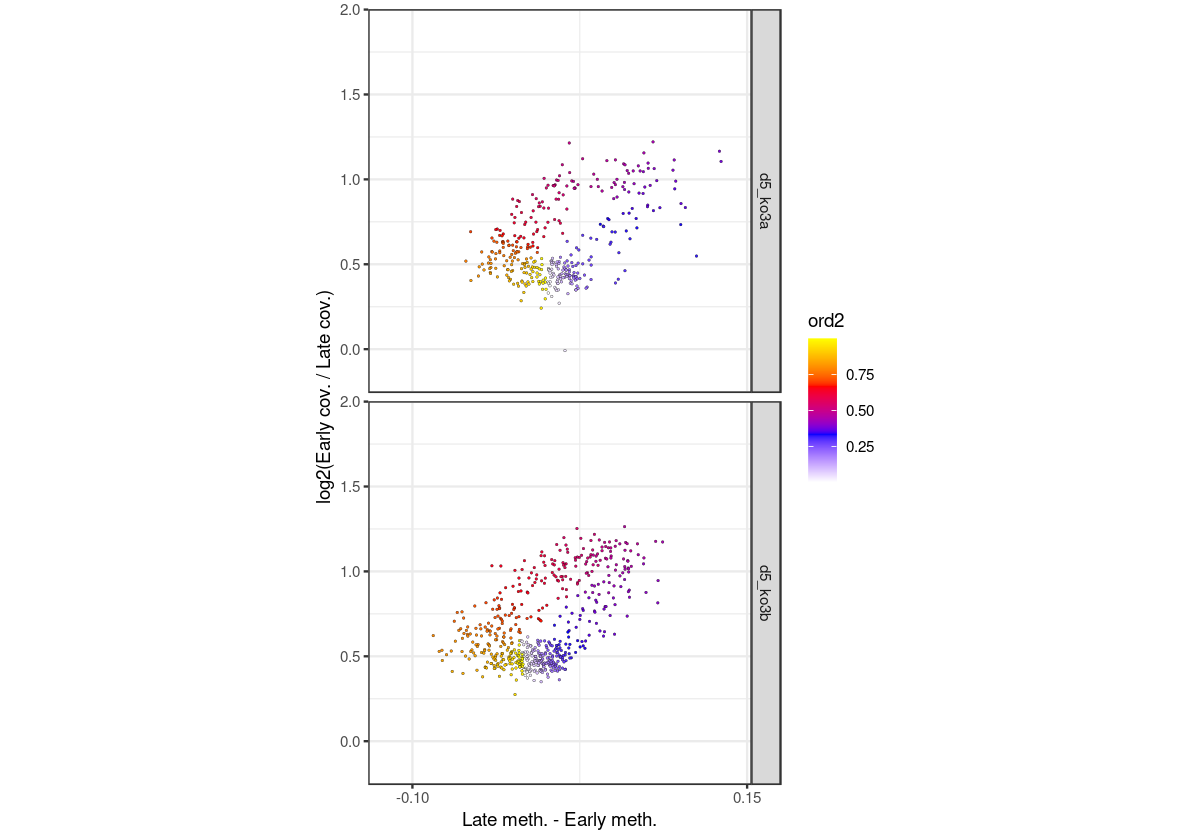

In [36]:
options(repr.plot.width = 10, repr.plot.height = 7)

p_el_ebs_circle_wt <- df_ord_ebs %>%         
    filter(line == "wt") %>% 
    plot_cc_circle(point_size=0.4) + 
    facet_grid(type~.) + 
    scale_x_continuous(breaks=c(-0.1, 0.15)) + 
    coord_cartesian(ylim = c(-0.15, 1.9), xlim=c(-0.12, 0.14))

p_el_ebs_circle_ko <- df_ord_ebs %>%         
    filter(line != "wt") %>% 
    plot_cc_circle(point_size=0.4) + 
    facet_grid(type~.) + 
    scale_x_continuous(breaks=c(-0.1, 0.15)) + 
    coord_cartesian(ylim = c(-0.15, 1.9), xlim=c(-0.12, 0.14))

p_el_ebs_circle_wt + theme_bw() + theme(aspect.ratio=1) 
p_el_ebs_circle_ko + theme_bw() + theme(aspect.ratio=1) 

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 39 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 39 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 12 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 12 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'



[[1]]

[[2]]


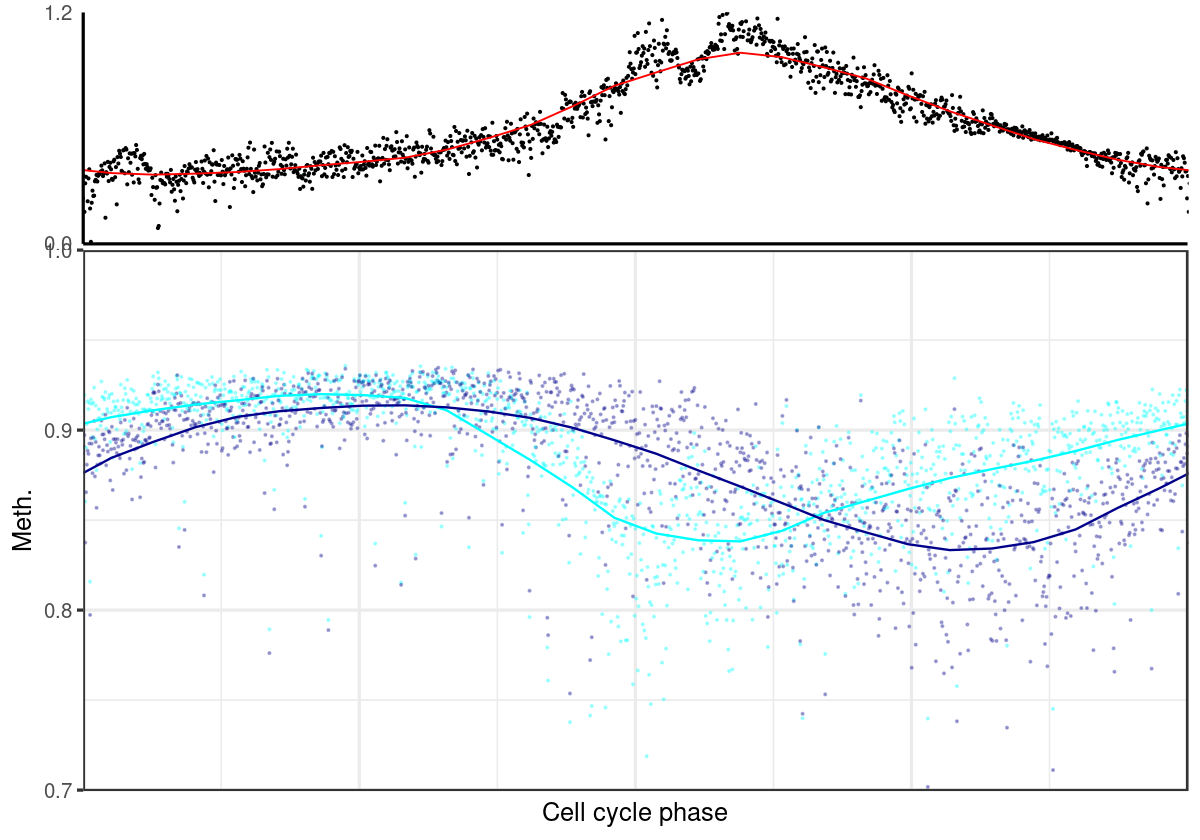

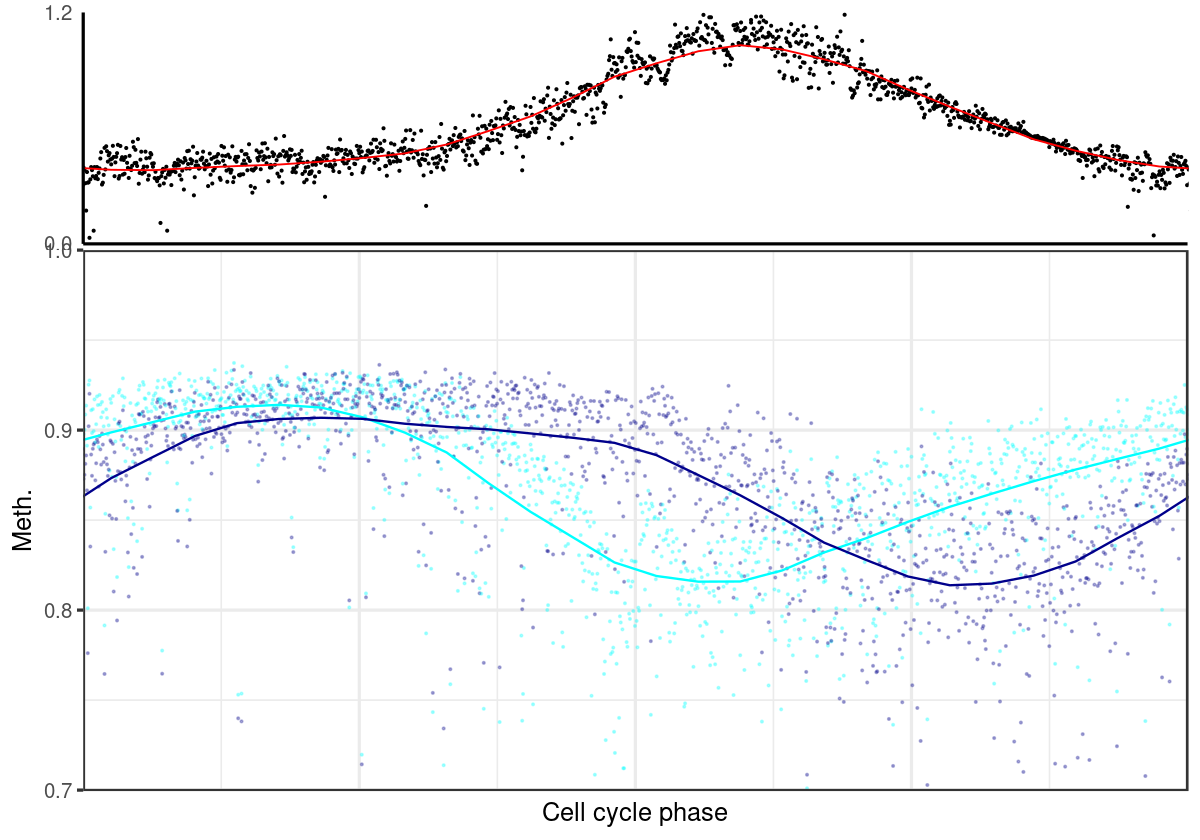

In [37]:
options(repr.plot.width = 10, repr.plot.height = 7)
dff <- df_ord_ebs %>%    
    filter(line == "wt") 

p_el_ebs_wt <- map(c("d6", "d5"), ~ dff %>% 
            filter(day == .x) %>% 
            plot_cc_early_late_meth(point_size=0.1, add_trend_lines = TRUE, y_lim = c(0.7, 1), plot_phase_lines = FALSE, trend_ylim = c(0,1.2)))

p_el_ebs_wt

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 9 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'



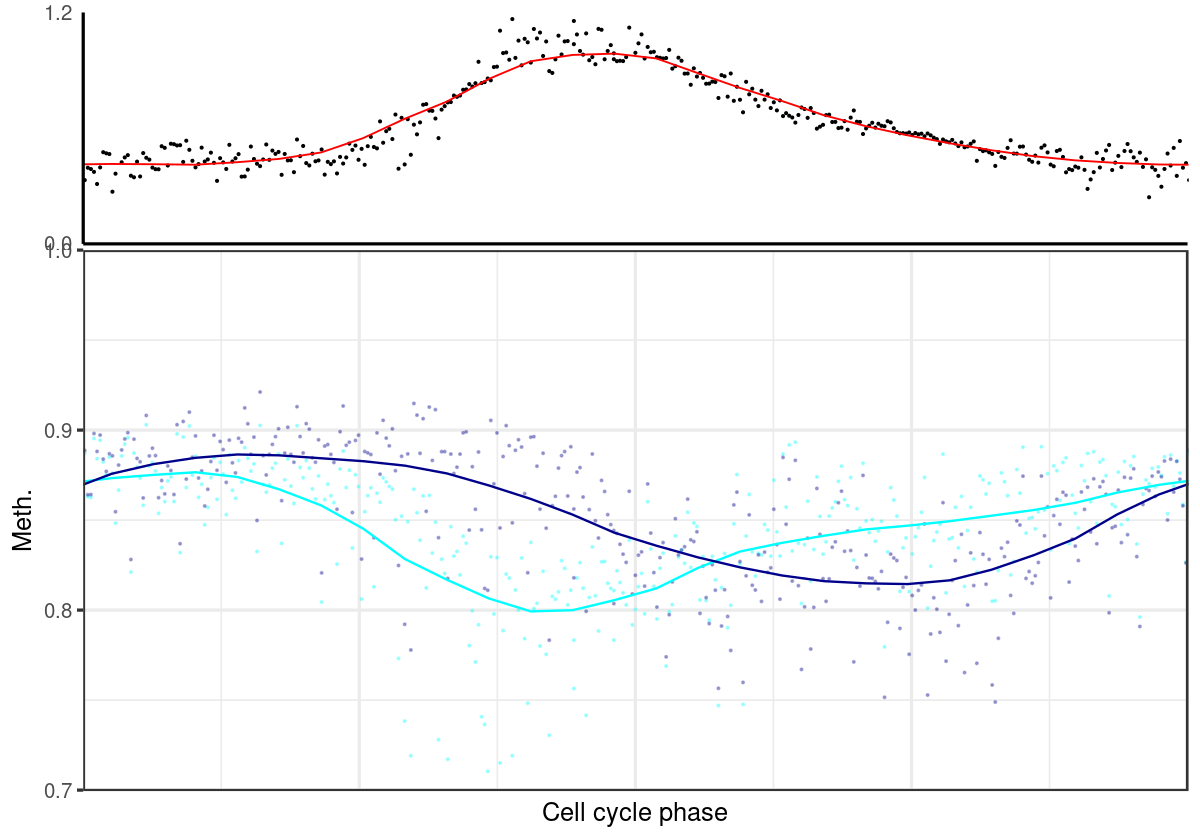

In [38]:
options(repr.plot.width = 10, repr.plot.height = 7)
dff <- df_ord_ebs %>%    
    filter(line != "wt") 

p_el_ebs_ko <- map(c("ko3a", "ko3b"), ~ dff %>% 
            filter(line == .x) %>% 
            plot_cc_early_late_meth(point_size=0.1, add_trend_lines = TRUE, y_lim = c(0.7, 1), plot_phase_lines = FALSE, trend_ylim = c(0,1.2)))

p_el_ebs_ko[[1]]

In [39]:
df_ord_ab_score_ebs %>% count(a_score, b_score)

ERROR: [1m[33mError[39m in [1m[1m`group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
Column `a_score` is not found.
Column `b_score` is not found.


#### Explanation

```math
ab_score = mA - mB = mA(ko) - mB(ko) = B - A
a_score = mA - mWT = mA(ko) - mWT = B - (A + B) = -A
b_score = mB - mWT = mB(ko) - mWT = A - (A + B) = -B
```

> (m prefix indicates methylation. Without prefix - activity.)

Therefore: 

-  Low `ab_score` => A > B, high `ab_score` => B > A
-  Low `a_score` => high activity of A
-  Low `b_score` => high activity of B

We will show:

1. Methylation of wt stratified by the activity of A and B (`ab_score`) 
2. Methylation of 3A-/- stratified by the activity of B (`b_score`)
3. Methylation of 3B-/- stratified by the activity of A (`a_score`) 

In [40]:
line_colors <- c("wt" = "darkblue", "ko3a" = "purple", "ko3b" = "orange")

df_ebs <- df_ord_ab_score_ebs %>% filter(day == "d5", cg_cont == '(0,0.02]') %>% distinct(cell_id, ord2, early_late_cov, day, line)


df_ebs_wt <- tor_ab_meth %>% 
    inner_join(df_ebs) %>% 
    filter(line == "wt") %>%     
    do({calc_cc_early_late_ab_diff(., low = "(-1.46,-0.734]", high = "(0.281,1.63]")})

# methylation of 3B-/- stratified by activity of A (a_score)
df_ebs_ko3b <- tor_a_meth %>% 
    inner_join(df_ebs) %>% 
    filter(line == "ko3b") %>% 
    rename(ab_score = a_score) %>% 
    do({calc_cc_early_late_ab_diff(., low = "(-1.21,-0.638]", high = "(0.125,0.678]")})

# methylation of 3A-/- stratified by activity of B (b_score)
df_ebs_ko3a <- tor_b_meth %>% 
    inner_join(df_ebs) %>% 
    filter(line == "ko3a") %>% 
    rename(ab_score = b_score) %>% 
    do({calc_cc_early_late_ab_diff(., low = "(-1,-0.17]", high = "(0.123,0.396]")})

df_ebs <- bind_rows(
    df_ebs_wt,
    df_ebs_ko3a,
    df_ebs_ko3b
) 

df_ebs <- df_ebs %>% 
    pivot_longer(names_sep="_", names_prefix="avg_", cols=starts_with("avg"), names_to=c("tor", "ab_score", "dummy"), values_to="avg") %>% 
    mutate(ab_score = forcats::fct_recode(factor(ab_score), "Favoring" = "l", "Opposing" = "h")) %>% 
    mutate(line = factor(line, levels = c("wt", "ko3b", "ko3a"))) %>% 
    filter(!is.na(line)) %>% 
    filter(cg_cont == "(0,0.02]") 

df_ebs <- df_ebs %>%     
    group_by(line, tor, ab_score) %>%
    mutate(trend = loess(avg~ord2, span=0.2)$fitted) %>% 
    group_by(line, tor, ab_score) %>% 
    mutate(max_ab = max(trend[ord2 <= 2 & ord2 >= 1], na.rm=TRUE)) %>% 
#     mutate(trend_norm = trend - max_ab)
    mutate(trend_norm = (trend - max_ab) / (max_ab / 2))

Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"


In [41]:
df_max_repli_ebs <- df_ebs %>% 
    group_by(line, tor) %>% 
    filter(ord2 <= 2, ord2 >= 1) %>% 
    summarise(s = ord2[which.max(early_late_cov)])
df_max_repli_ebs

line,tor,s
<fct>,<chr>,<dbl>
wt,early,1.604009
wt,late,1.604009
ko3b,early,1.463781
ko3b,late,1.463781
ko3a,early,1.441504
ko3a,late,1.441504


### Figure 6F,G, Extended Data Figure 9I

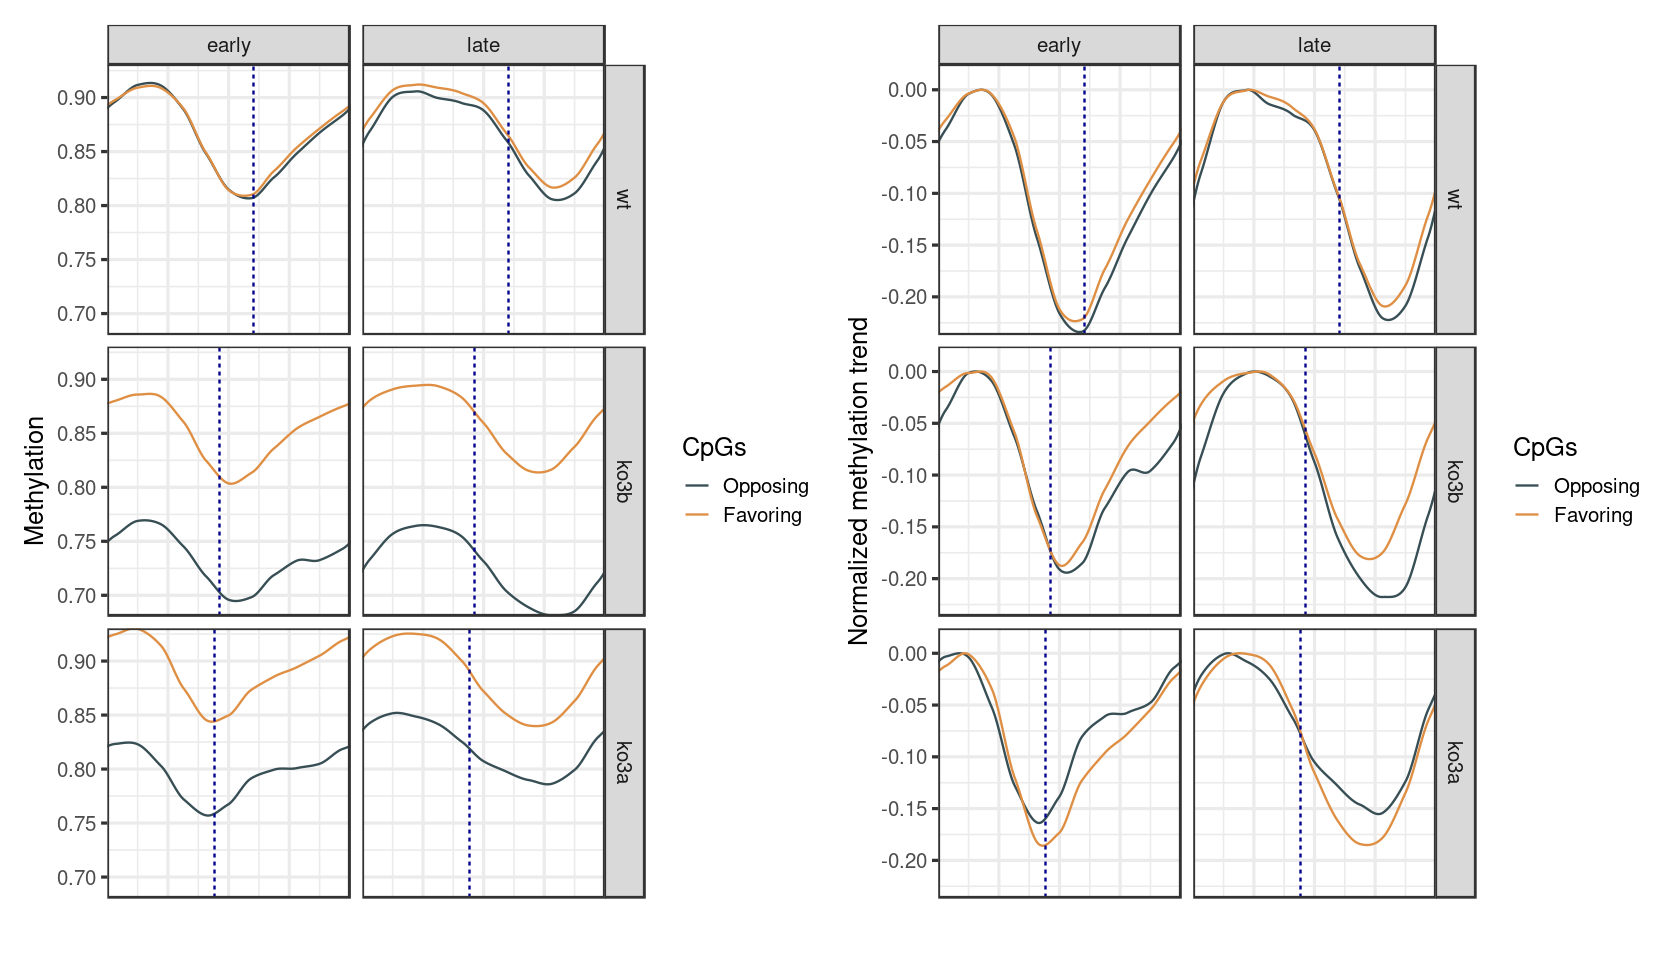

In [42]:
p_ab_trend_ebs1 <- df_ebs %>%
    ggplot(aes(x=ord2, y=trend, color=ab_score)) + 
        geom_line(size=0.5) + 
        coord_cartesian(xlim=c(1,2), expand=0) + 
        ggsci::scale_color_jama(name = "CpGs") + 
        geom_vline(aes(xintercept = s), data = df_max_repli_ebs, color = "darkblue", linetype = "dashed") + 
        facet_grid(line~tor) +  
        xlab("") + 
        ylab("Methylation") + 
        theme(
            axis.text.x = element_blank(), 
            axis.ticks.x = element_blank()
        ) 

p_ab_trend_ebs_norm <- df_ebs %>%
    ggplot(aes(x=ord2, y=trend_norm, color=ab_score)) + 
        geom_line(size=0.5) + 
        coord_cartesian(xlim=c(1,2), expand=0) + 
        ggsci::scale_color_jama(name = "CpGs") + 
        geom_vline(aes(xintercept = s), data = df_max_repli_ebs, color = "darkblue", linetype = "dashed") + 
        facet_grid(line~tor) +  
        xlab("") + 
        ylab("Normalized methylation trend") + 
        theme(
            axis.text.x = element_blank(), 
            axis.ticks.x = element_blank()
        ) 

options(repr.plot.width = 14, repr.plot.height = 8)
p_ab_trend_ebs1 + p_ab_trend_ebs_norm

    

Using the ab-score

In [43]:
line_colors <- c("wt" = "darkblue", "ko3a" = "purple", "ko3b" = "orange")

df_ebs <- df_ord_ab_score_ebs %>% filter(day == "d5", cg_cont == '(0,0.02]') %>% 
    group_by(line) %>% 
    do({calc_cc_early_late_ab_diff(., low = "(-1.46,-0.734]", high = "(0.281,1.63]")}) %>% 
    ungroup() %>% 
    mutate(line = factor(line, levels = names(line_colors))) %>% 
    filter(!is.na(line)) 

df_ebs <- df_ebs %>% 
    pivot_longer(names_sep="_", names_prefix="avg_", cols=starts_with("avg"), names_to=c("tor", "ab_score", "dummy"), values_to="avg") %>% 
    mutate(ab_score = forcats::fct_recode(factor(ab_score), "A-phil" = "l", "B-phil" = "h")) %>% 
    mutate(line = factor(line, levels = names(line_colors))) %>% 
    filter(!is.na(line)) %>% 
    filter(cg_cont == "(0,0.02]") 

In [44]:
df_max_repli_ebs <- df_ebs %>% 
    group_by(line, tor) %>% 
    filter(ord2 <= 2, ord2 >= 1) %>% 
    summarise(s = ord2[which.max(early_late_cov)])
df_max_repli_ebs

line,tor,s
<fct>,<chr>,<dbl>
wt,early,1.604009
wt,late,1.604009
ko3a,early,1.441504
ko3a,late,1.441504
ko3b,early,1.463781
ko3b,late,1.463781


### Figure 6D

`geom_smooth()` using formula 'y ~ x'



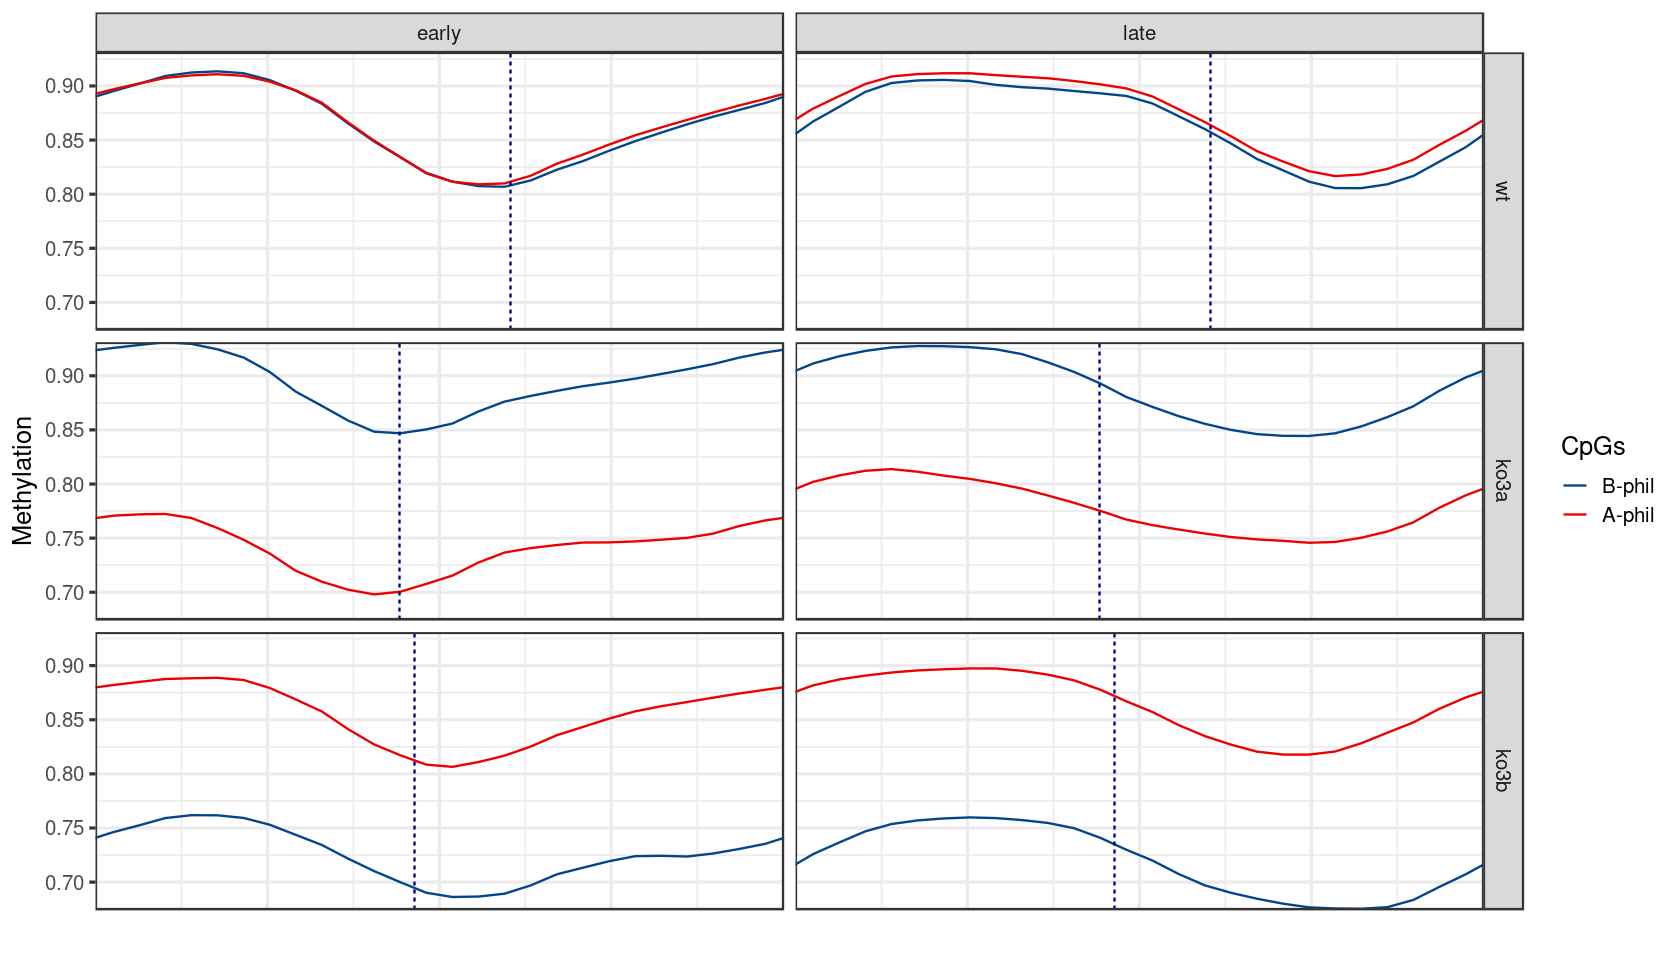

In [45]:
p_ab_trend_ebs <- df_ebs %>%
    ggplot(aes(x=ord2, y=avg, color=ab_score)) + 
        geom_smooth(method="loess", span=0.2, se=FALSE, size=0.5) + 
        coord_cartesian(xlim=c(1,2), expand=0) + 
        ggsci::scale_color_lancet(name = "CpGs") + 
        geom_vline(aes(xintercept = s), data = df_max_repli_ebs, color = "darkblue", linetype = "dashed") +
        facet_grid(line~tor) +  
        xlab("") + 
        ylab("Methylation") + 
        theme(
            axis.text.x = element_blank(), 
            axis.ticks.x = element_blank()
        ) 

p_ab_trend_ebs

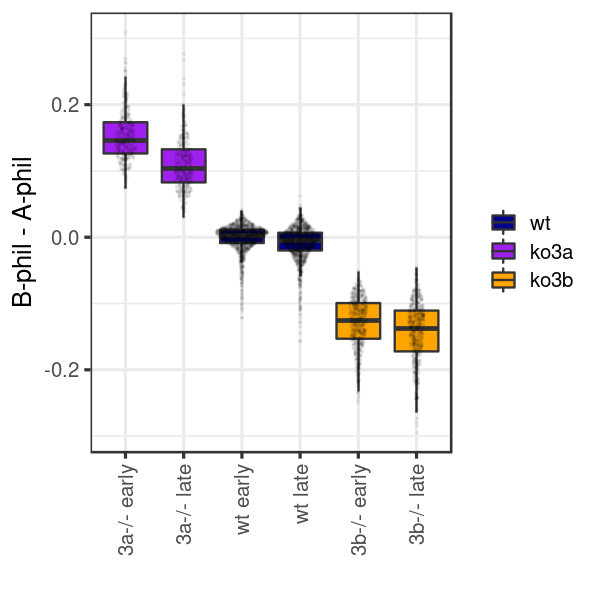

In [46]:
options(repr.plot.width = 5, repr.plot.height = 5)

line_colors <- c("wt" = "darkblue", "ko3a" = "purple", "ko3b" = "orange")

df_diff <- df_ebs %>% distinct(cell_id, cg_cont, day, line, ord2, tor, ab_score, avg)  %>% spread(ab_score, avg) %>% mutate(diff = `B-phil` - `A-phil`) %>% filter(ord2 >= 1, ord2 <= 2)

p_diff <- df_diff %>% 
    mutate(line = factor(line, levels = names(line_colors))) %>% 
    unite("type", line, tor, sep=" ", remove=FALSE) %>% 
    group_by(type) %>% 
    mutate(mean_diff = mean(diff)) %>% 
    ungroup() %>% 
    mutate(type = gsub("ko3a", "3a-/-", type), 
          type = gsub("ko3b", "3b-/-", type)
          ) %>%
    mutate(type = forcats::fct_reorder(type, -mean_diff)) %>%
    ggplot(aes(x=type, y=diff, fill=line)) + 
        geom_boxplot(outlier.shape=NA) +         
        scale_fill_manual(name="", values=line_colors) + 
        ylab("B-phil - A-phil") + 
        xlab("") + 
        ggforce::geom_sina(size=0.01, alpha=0.05) + 
        vertical_labs()

p_diff

## Plot other EB batches

In [47]:
df_cell_cycle_eb_other <- df_cell_cycle_annot %>%  
    filter(line != "mouse", day %in% c("d5", "d6"), (experiment %in% paste0("experiment", c(5,6,8))), avg_early >= 0.7, avg_late >= 0.7) %>% 
    select(cell_id, day, line, sort, experiment, avg_late, avg_early, early, late, early_late_cov, early_late_diff = meth_late_early_diff)

In [48]:
l_ebs_other <- df_cell_cycle_eb_other %>% add_count(day, line) %>% filter(n >= 50) %>% as.data.frame() %>% plyr::dlply(c("day", "line"), function(x) calc_cell_cycle_ord(as_tibble(x)))

Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"
Joining, by = "cell_id"


In [49]:
df_ord_ebs_other <- l_ebs_other %>% 
    map_dfr(~ .$df) %>% 
    as_tibble() %>% 
    unite("type", day:line, remove=FALSE) %>% 
    group_by(day, line) %>%         
    arrange(day, line, desc(early_late_cov) ) %>% 
    mutate(
        new_ord = ord - ord[1] + 1, 
        new_ord = ifelse(new_ord >= 0, new_ord, max(new_ord) + abs(min(new_ord)) - abs(new_ord)),
        ord1 = new_ord / max(new_ord)
    ) %>%    
    mutate(
        trend = zoo::rollmean(early_late_cov[order(ord1)], 20, na.pad = TRUE),
        i_mid = zoo::rollmean(ord1[order(ord1)],20)[which.min(trend)],
        ord2 = i_mid - ord1,
        ord2 = ord2 - floor(ord2)
    ) %>% 
    mutate(type = factor(type, levels = c("d6_wt", "d5_wt", "d5_ko3a", "d5_ko3b", "d6_ko3a", "d6_ko3b"))) %fcache_df% here("output/cell_cycle/ebs_other.tsv")

In [50]:
df_ord_cgc_ebs_other <- tor_cgc_meth %>% 
    inner_join(df_ord_ebs_other %>% select(cell_id, day, line, type, ord2, early_late_cov)) 
df_ord_ab_score_ebs_other <- tor_ab_meth %>% 
    inner_join(df_ord_ebs_other %>% select(cell_id, day, line, type, ord2, early_late_cov))

Joining, by = "cell_id"
Joining, by = "cell_id"


In [51]:
df_ord_ebs_other <- df_ord_ebs_other %>% filter(day == "d5")

### Extended Data Figure 9H

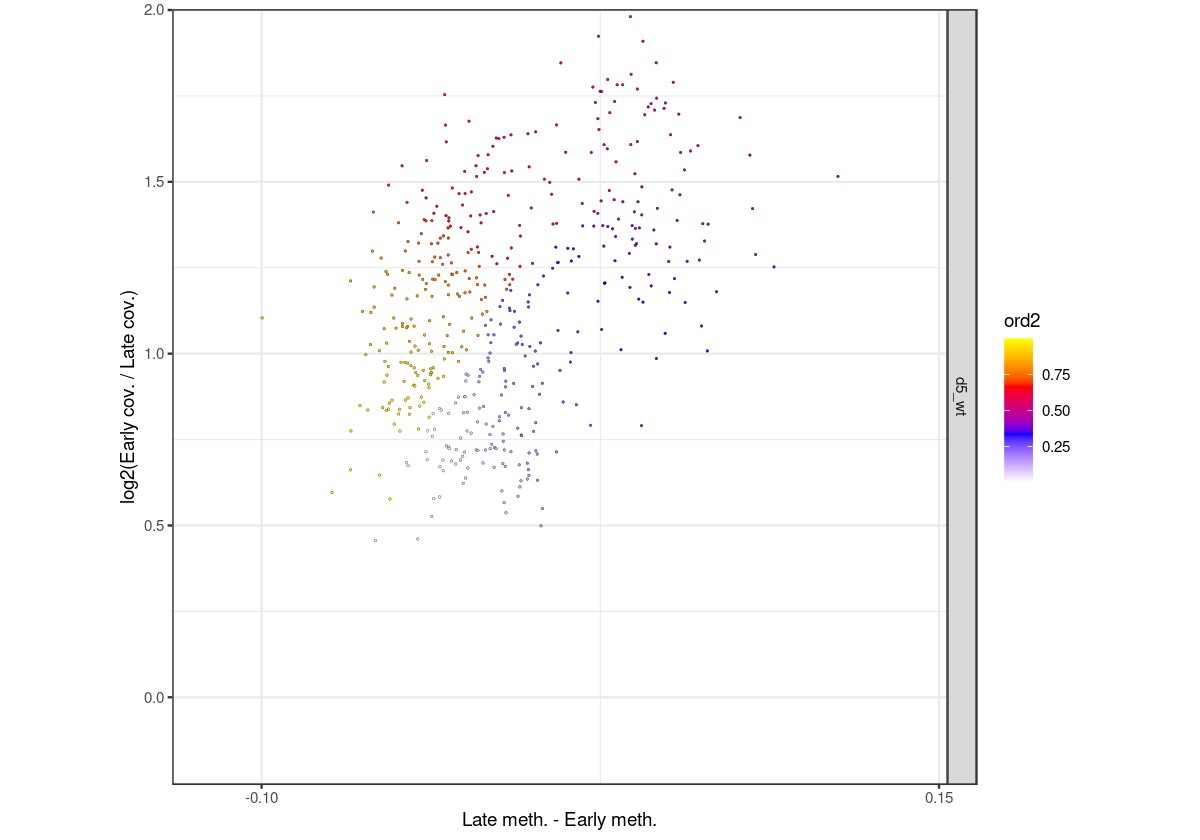

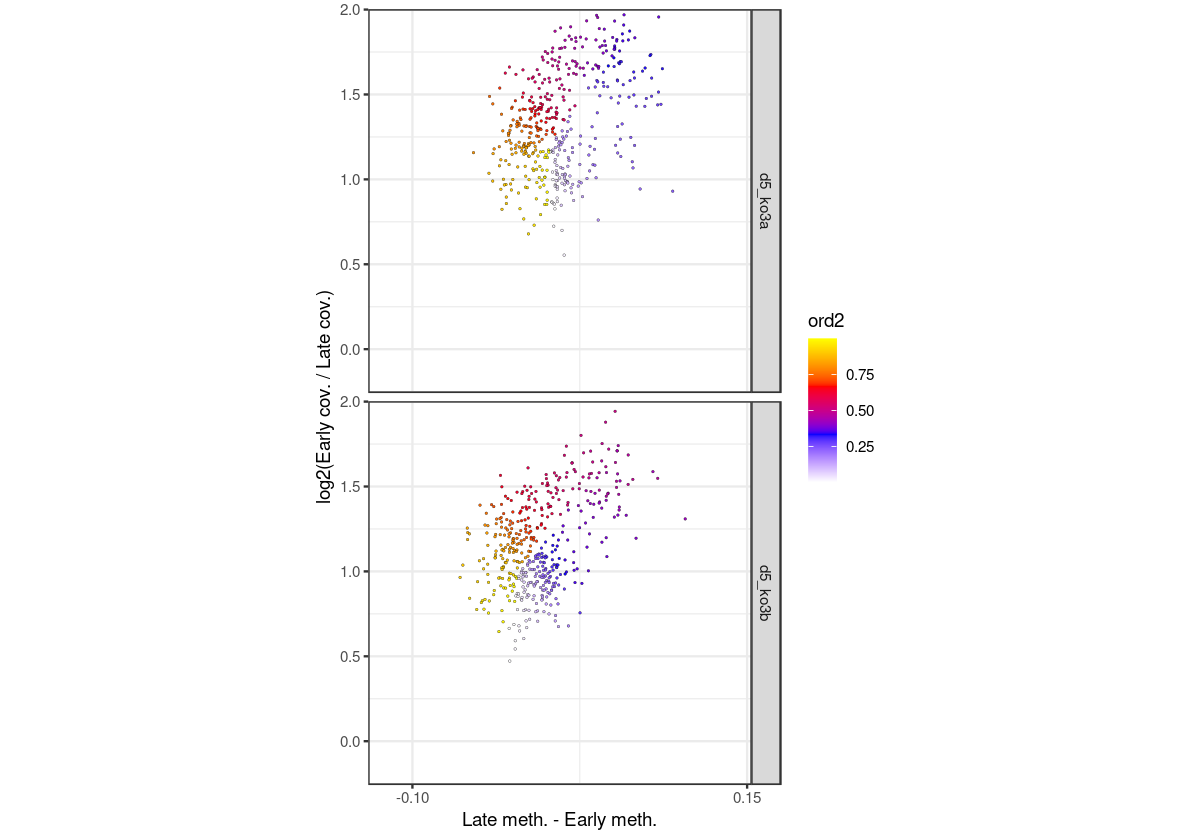

In [52]:
options(repr.plot.width = 10, repr.plot.height = 7)

p_el_ebs_circle_wt_other <- df_ord_ebs_other %>%         
    filter(line == "wt") %>% 
    plot_cc_circle(point_size=0.4) + 
    facet_grid(type~.) + 
    scale_x_continuous(breaks=c(-0.1, 0.15)) + 
    coord_cartesian(ylim = c(-0.15, 1.9), xlim=c(-0.12, 0.14))

p_el_ebs_circle_ko_other <- df_ord_ebs_other %>%         
    filter(line != "wt") %>% 
    plot_cc_circle(point_size=0.4) + 
    facet_grid(type~.) + 
    scale_x_continuous(breaks=c(-0.1, 0.15)) + 
    coord_cartesian(ylim = c(-0.15, 1.9), xlim=c(-0.12, 0.14))

p_el_ebs_circle_wt_other + theme_bw() + theme(aspect.ratio=1) 
p_el_ebs_circle_ko_other + theme_bw() + theme(aspect.ratio=1) 